This tutorial demostrates Pointer Networks with readable code.

In [1]:
import math
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

USE_CUDA = True

In [2]:
from IPython.display import clear_output
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

<h3>Generating dataset for sorting task</h3>

In [3]:
class SortDataset(Dataset):
    
    def __init__(self, data_len, num_samples, random_seed=111):
        super(SortDataset, self).__init__()
        torch.manual_seed(random_seed)

        self.data_set = []
        for _ in tqdm(range(num_samples)):
            x = torch.randperm(data_len)
            self.data_set.append(x)

        self.size = len(self.data_set)

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        return self.data_set[idx]

In [4]:
train_size = 1000
val_size = 100

In [5]:
train_dataset = SortDataset(10, train_size)
val_dataset   = SortDataset(10, val_size)

100%|██████████| 100/100 [00:00<00:00, 99983.41it/s]


<h3>Attention mechanism</h3>
<p>
Using two types of attention mechanism: "Dot" and "Bahdanau" . More details in <a href="http://aclweb.org/anthology/D15-1166">Effective Approaches to Attention-based Neural Machine Translation</a></p>

$$
a_t(s) = align(h_t, \bar h_s)  = \dfrac{exp(score(h_t, \bar h_s))}{\sum_{s'} exp(score(h_t, \bar h_{s'}))}
$$

$$
score(h_t, \bar h_s) =
\begin{cases}
h_t ^\top \bar h_s & Dot \\
v_a ^\top \tanh(\textbf{W}_a [ h_t ; \bar h_s ]) & Bahdanau
\end{cases}
$$

In [6]:
class Attention(nn.Module):
    def __init__(self, hidden_size, use_tanh=False, C=10, use_cuda=USE_CUDA):
        super(Attention, self).__init__()
        
        self.use_tanh = use_tanh
        self.W_query = nn.Linear(hidden_size, hidden_size)
        self.W_ref   = nn.Conv1d(hidden_size, hidden_size, 1, 1)
        self.C = C
        
        V = torch.FloatTensor(hidden_size)
        if use_cuda:
            V = V.cuda()  
        self.V = nn.Parameter(V)
        self.V.data.uniform_(-(1. / math.sqrt(hidden_size)) , 1. / math.sqrt(hidden_size))
        
    def forward(self, query, ref):
        """
        Args: 
            query: [batch_size x hidden_size]
            ref:   [batch_size x seq_len x hidden_size]
        """
        
        batch_size = ref.size(0)
        seq_len    = ref.size(1)

        ref = ref.permute(0, 2, 1) # (batch_size, hidden_size, seq_len)
        query = self.W_query(query).unsqueeze(2)  # (batch_size, hidden_size, 1)
        ref   = self.W_ref(ref)  # (batch_size, hidden_size, seq_len)

        expanded_query = query.repeat(1, 1, seq_len) # (batch_size, hidden_size, seq_len)
        V = self.V.unsqueeze(0).unsqueeze(0).repeat(batch_size, 1, 1) # (batch_size, 1, hidden_size)

        logits = torch.bmm(V, F.tanh(expanded_query + ref)).squeeze(1) # (batch_size, seq_len)
        
        if self.use_tanh:
            logits = self.C * F.tanh(logits)
        else:
            logits = logits
        return ref, logits

<h3>Pointer Network</h3>
<p><a href="https://arxiv.org/abs/1506.03134">Pointer Networks
</a></p>
<p>The model solves the problem of variable size output dictionaries using a recently proposed mechanism of neural attention. It differs from the previous attention attempts in that, instead of using attention to blend hidden units of an encoder to a context vector at each decoder step, it uses attention as a pointer to select a member of the input sequence as the output.</p>
<img src="./imgs/Снимок экрана 2017-12-26 в 4.30.58 ДП.png">

In [7]:
class PointerNet(nn.Module):
    def __init__(self,
            embedding_size,
            hidden_size,
            seq_len,
            n_glimpses,
            tanh_exploration,
            use_tanh,
            use_cuda=USE_CUDA):
        super(PointerNet, self).__init__()
        
        self.embedding_size = embedding_size
        self.hidden_size    = hidden_size
        self.n_glimpses     = n_glimpses
        self.seq_len        = seq_len
        self.use_cuda       = use_cuda
        
        
        self.embedding = nn.Embedding(seq_len, embedding_size) # vocabulary size is also seq length
        self.encoder = nn.LSTM(embedding_size, hidden_size, batch_first=True)
        self.decoder = nn.LSTM(embedding_size, hidden_size, batch_first=True)
        self.pointer = Attention(hidden_size, use_tanh=use_tanh, C=tanh_exploration, use_cuda=use_cuda)
        self.glimpse = Attention(hidden_size, use_tanh=False, use_cuda=use_cuda)
        
        self.decoder_start_input = nn.Parameter(torch.FloatTensor(embedding_size))
        self.decoder_start_input.data.uniform_(-(1. / math.sqrt(embedding_size)), 1. / math.sqrt(embedding_size))
        
        self.criterion = nn.CrossEntropyLoss()
        
    def apply_mask_to_logits(self, logits, mask, idxs):
        # mask: (batch_size, seq_len)
        # idxs: (batch_size,)
        batch_size = logits.size(0)
        clone_mask = mask.clone()

        if idxs is not None:
            clone_mask[[i for i in range(batch_size)], idxs.data] = 1
            logits[clone_mask] = -np.inf
        return logits, clone_mask
            
    def forward(self, inputs, target):
        """
        Args:
            inputs: [batch_size x sourceL]
        """
        # inputs: (batch_size, seq_len)
        batch_size = inputs.size(0)
        seq_len    = inputs.size(1)
        assert seq_len == self.seq_len
        
        embedded = self.embedding(inputs) # (batch_size, seq_len, embedding_size)
        target_embedded = self.embedding(target) # (batch_size, seq_len, embedding_size)
        encoder_outputs, (hidden, context) = self.encoder(embedded)
        # encoder_outputs: (batch_size, seq_len, hidden_size)
        
        mask = torch.zeros(batch_size, seq_len).byte()
        if self.use_cuda:
            mask = mask.cuda()
            
        idxs = None
       
        decoder_input = self.decoder_start_input.unsqueeze(0).repeat(batch_size, 1) # (batch_size, embedding_size)
        
        loss = 0
        
        for i in range(seq_len):
            
            _, (hidden, context) = self.decoder(decoder_input.unsqueeze(1), (hidden, context))
            # hidden: (1, batch_size, hidden_size), 1 means single direction and rnn-layer

            query = hidden.squeeze(0) # (batch_size, hidden_size)
            #for i in range(self.n_glimpses):
            for _ in range(self.n_glimpses):
                ref, logits = self.glimpse(query, encoder_outputs)
                # ref: (batch_size, hidden_size, seq_len)
                # logits: (batch_size, seq_len)
                logits, mask = self.apply_mask_to_logits(logits, mask, idxs)
                query = torch.bmm(ref, F.softmax(logits).unsqueeze(2)).squeeze(2) # (batch_size, hidden)
                
            _, logits = self.pointer(query, encoder_outputs) # (batch_size, seq_len)
            logits, mask = self.apply_mask_to_logits(logits, mask, idxs)
            
            decoder_input = target_embedded[:,i,:]
            # (batch_size, embedding_size)
            
            loss += self.criterion(logits, target[:,i])
            
            
        return loss / seq_len

In [8]:
pointer = PointerNet(embedding_size=32, hidden_size=32, seq_len=10, n_glimpses=1, tanh_exploration=10, use_tanh=True)
adam = optim.Adam(pointer.parameters(), lr=1e-4)

if USE_CUDA:
    pointer = pointer.cuda()

In [9]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True) # remove num_workers, let it be 0
val_loader   = DataLoader(val_dataset, batch_size=4, shuffle=True)

<h3>Train and Validate</h3>

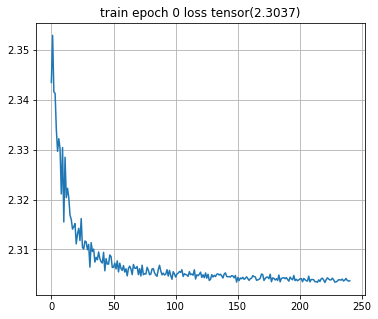

In [10]:
n_epochs = 1
train_loss = []
val_loss   = []

for epoch in range(n_epochs):
    for batch_id, sample_batch in enumerate(train_loader):
        inputs = sample_batch
        target = torch.sort(sample_batch)[0]
        if USE_CUDA:
            inputs = inputs.cuda()
            target = target.cuda()

        loss = pointer(inputs, target)

        adam.zero_grad()
        loss.backward()
        adam.step()
        
        train_loss.append(loss.data.cpu())

        if batch_id % 10 == 0:

            clear_output(True)
            plt.figure(figsize=(20,5))
            plt.subplot(131)
            plt.title('train epoch %s loss %s' % (epoch, train_loss[-1] if len(train_loss) else 'collecting'))
            plt.plot(train_loss)
            plt.grid()

            # In fact eval is not supported, because training method is teacher forcing,
            # and there is no step-by-step predicting method.

            #plt.subplot(132)
            #plt.title('val epoch %s loss %s' % (epoch, val_loss[-1] if len(val_loss) else 'collecting'))
            #plt.plot(val_loss)
            #plt.grid()
            
            plt.show()
        
        #if batch_id % 100 == 0:
        #    pointer.eval()
        #    for val_batch in val_loader:
        #        inputs = Variable(val_batch)
        #        target = Variable(torch.sort(val_batch)[0])
        #        if USE_CUDA:
        #            inputs = inputs.cuda()
        #            target = target.cuda()
        #
        #        loss = pointer(inputs, target)
        #        val_loss.append(loss.data[0])